<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler,StandardScaler

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
def load_data(file_dir):
    data = pd.read_csv(file_dir,sep=';',
                    header=0,low_memory=False,
                    infer_datetime_format=True,
                    parse_dates={'datetime':[0,1]},
                    index_col=['datetime'])
    return data
def clean_data(data):
  data.replace('?',np.NaN,inplace=True)
  data = data.fillna(method='bfill')
  data = data.astype('float32')
  return data

def scaling_data(data):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(data)
  return scaled,scaler

def series_to_supervised(df_as_np,n_lags,n_out=1):
  X,y = [],[]
  for i in range(len(df_as_np)-n_lags):
    row = [ a for a in df_as_np[i:i+n_lags]]
    X.append(row)
    label = df_as_np[i+n_lags:i+n_lags+n_out,0]
    y.append(label)
  return np.array(X), np.array(y)

In [131]:
dataset = load_data(r'/content/drive/MyDrive/datasets/household_power_consumption.txt')

In [141]:
cols=['Global_active_power', 'Global_reactive_power', 'Global_intensity']
dataset = dataset[cols]
dataset = clean_data(dataset)

(array([3.000000e+00, 3.400000e+01, 7.290000e+02, 9.220000e+03,
        6.642300e+04, 1.955019e+06, 3.948900e+04, 3.851000e+03,
        4.630000e+02, 2.600000e+01]),
 array([-31.399998 , -25.559998 , -19.719997 , -13.879998 ,  -8.039999 ,
         -2.1999989,   3.6400008,   9.4800005,  15.320001 ,  21.16     ,
         27.       ], dtype=float32),
 <a list of 10 Patch objects>)

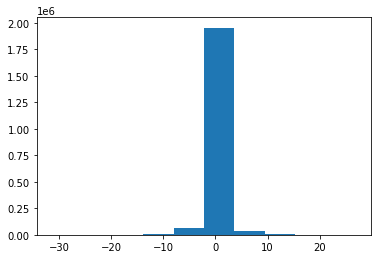

In [151]:
x = (dataset.Global_intensity.values*2)-dataset.Global_intensity.shift(1) - dataset.Global_intensity.shift(-1)
abs(x) > 10

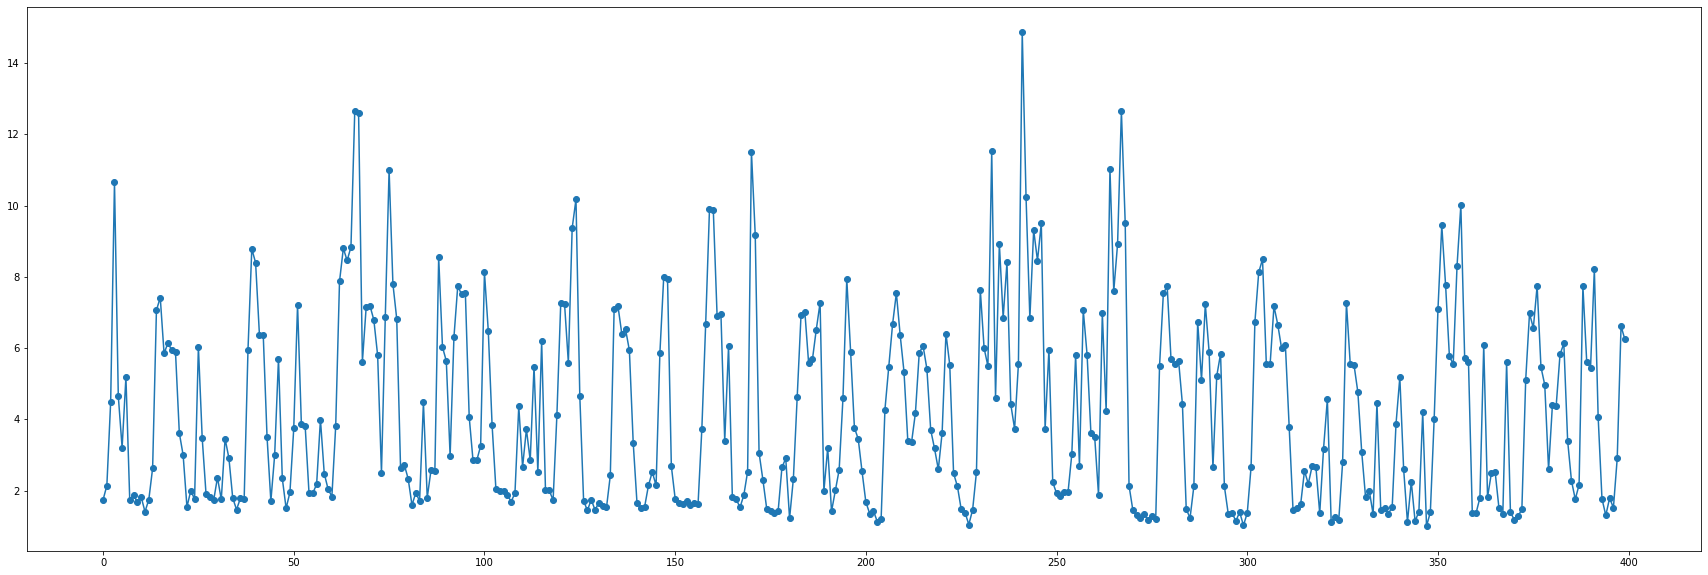

In [159]:
plt.figure(figsize=(30,10))
plt.plot(dataset.Global_intensity.values[30000:30400],marker='o')

(array([1.6923e+04, 7.4050e+03, 5.6410e+03, 2.6570e+03, 1.2100e+03,
        4.7800e+02, 1.8200e+02, 6.8000e+01, 1.6000e+01, 9.0000e+00]),
 array([ 0.50333333,  3.2913332 ,  6.0793333 ,  8.867333  , 11.6553335 ,
        14.443334  , 17.231333  , 20.019333  , 22.807333  , 25.595333  ,
        28.383333  ], dtype=float32),
 <a list of 10 Patch objects>)

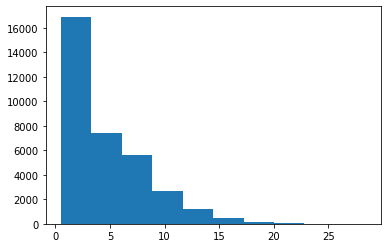

In [158]:
plt.hist(dataset.Global_intensity.values)

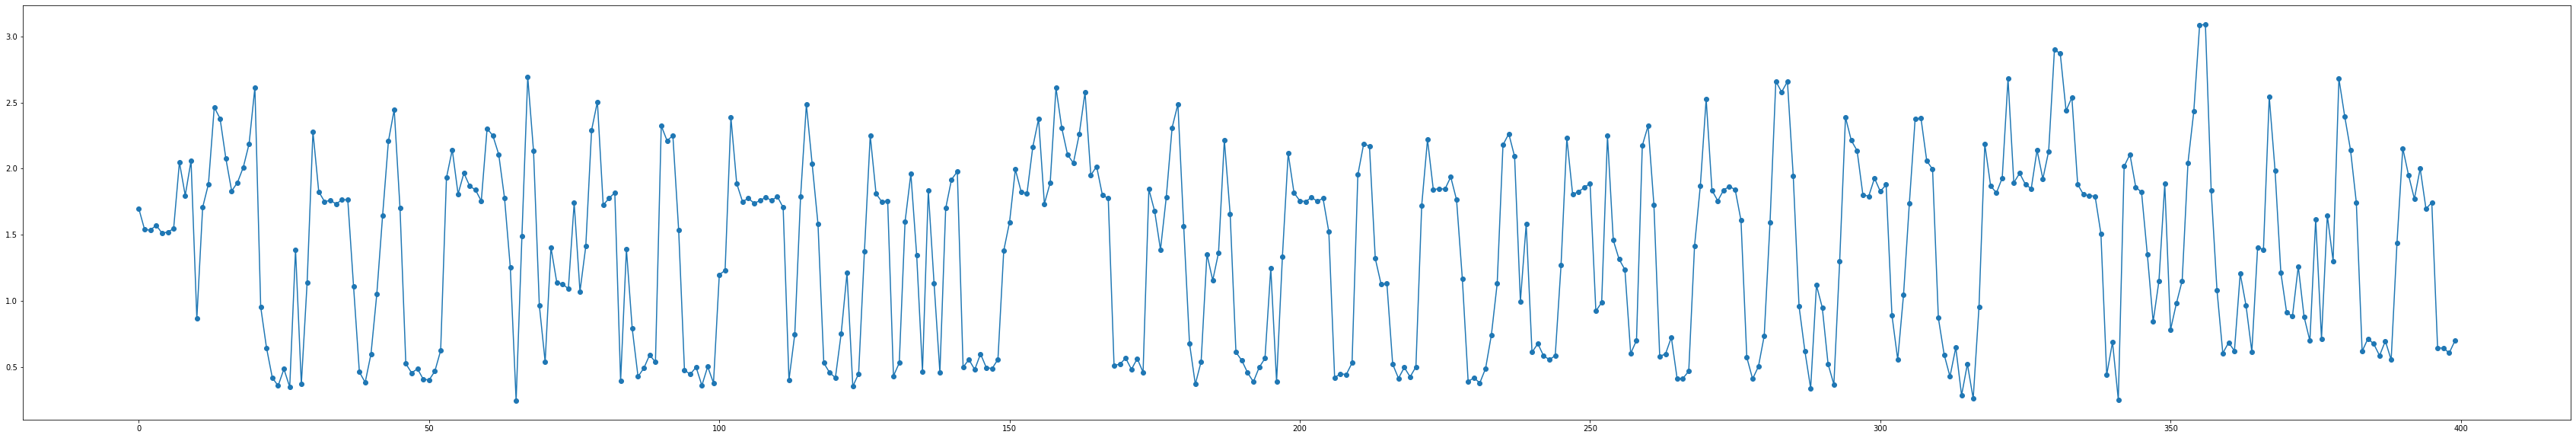

In [161]:
dataset = dataset.resample('H').mean()
plt.figure(figsize=(60,10))
plt.plot(dataset.Global_intensity.values[20000:20400],marker='o')

In [120]:
cols=['Global_active_power', 'Global_reactive_power', 'Global_intensity']
dataset = dataset[cols]
dataset = clean_data(dataset)
dataset = dataset.resample('H').mean()
data_as_np,scaler = scaling_data(dataset)
n_lags=120
n_out=1
input,target = series_to_supervised(data_as_np,n_lags,n_out)
input , target = input[500:],target[500:]
train_input = input[:23000]
test_input = input[26000:]
validation_input = input[23000:26000]
train_target = target[:23000]
test_target = target[26000:]
validation_target = target[23000:26000]
train_input.shape,test_input.shape,train_target.shape,test_target.shape

((23000, 120, 3), (7969, 120, 3), (23000, 1), (7969, 1))

In [ ]:
#date_index=new_data.index.to_series()
#new_data['year']=date_index.dt.year
#new_data['month']=date_index.dt.month
#new_data['day_of_week']=date_index.dt.dayofweek
#new_data['hour']=date_index.dt.hour
#new_data = new_data.reset_index(drop=True)

#new_data['hour_cos'] = np.cos(2 * np.pi * new_data['hour'] / 24)
#new_data['hour_sin'] = np.sin(2 * np.pi * new_data['hour'] / 24)

#new_data['Global_active_power'] = 1000*new_data['Global_active_power']

#new_data.drop(labels=['hour'],axis=1,inplace=True)
#new_data.drop(labels=['Global_active_power'],axis=1,inplace=True)

In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float32
 1   Global_reactive_power  34589 non-null  float32
 2   Global_intensity       34589 non-null  float32
dtypes: float32(3)
memory usage: 675.6 KB


# Models...

**model1..LSTM**

In [112]:
def create_model(input_shape):
  model = Sequential()
  # input layer...
  model.add(LSTM(100,activation='relu',input_shape = input_shape))
  model.add(Dropout(0.2))
  model.add(Dense(8, 'relu'))
  #output layer...
  model.add(Dense(1, 'linear'))

  model.summary()
  return model

In [121]:
input_shape = (n_lags, len(cols))
model =create_model(input_shape)
cp1 = ModelCheckpoint('model1/', save_best_only=True)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model_summary = model.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=20, batch_size=70, callbacks=[cp1])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               41600     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 808       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 42,417
Trainable params: 42,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
329/329 [==============================] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1369INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 49s 145ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 2/20
329/329 [==============================] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1210INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 48s 145ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 3/20
329/329 [==============================] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.1158INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 47s 142ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 4/20
329/329 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1117INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 46s 141ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 5/20
329/329 [==============================] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1092INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 47s 143ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 6/20
329/329 [==============================] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1068INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 46s 140ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 7/20
329/329 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1055INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 46s 141ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 8/20
329/329 [==============================] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1039INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 46s 141ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 9/20
329/329 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1030INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 47s 143ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 10/20
329/329 [==============================] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1023INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 132ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 11/20
329/329 [==============================] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1016INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 131ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 12/20
329/329 [==============================] - 40s 123ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 13/20
329/329 [==============================] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1008INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 130ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 14/20
329/329 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.1001INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 131ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 15/20
329/329 [==============================] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0997INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 45s 137ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 16/20
329/329 [==============================] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0994INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 132ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 17/20
329/329 [==============================] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0993INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 131ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 18/20
329/329 [==============================] - 40s 123ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 19/20
329/329 [==============================] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0989INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


329/329 [==============================] - 43s 129ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 20/20
329/329 [==============================] - 41s 123ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952


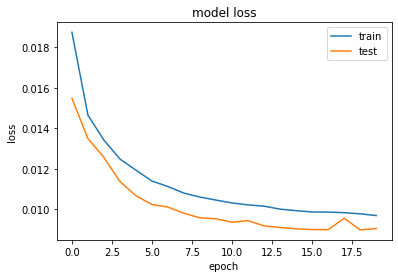

In [122]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(model_summary.history['loss'])
plt.plot(model_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [123]:
model1 = load_model('model1/')

In [124]:
train_predicted = model1.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [125]:
test_predictions = model1.predict(test_input).flatten()
shape = (test_predictions.shape[0],1)
test_predicted = scaler.inverse_transform(np.concatenate((test_predictions.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_target = scaler.inverse_transform(np.concatenate((test_target.reshape(-1,1),np.ones(shape),np.ones(shape)),axis=1))[:,0]
test_results = pd.DataFrame(data={'test_predicted':test_predicted, 'test_target':test_target})
test_results

,test_predicted,test_target
0,0.790232,0.952567
1,0.818858,1.347467
2,1.341556,1.153667
3,1.379065,0.363700
4,0.758919,0.353500
...,...,...
7964,1.288536,1.725900
7965,1.603483,1.573467
7966,1.517025,1.659333
7967,1.539290,1.163700


In [126]:
np.mean(abs(test_results.test_predicted-test_results.test_target)/test_results.test_target)

0.5028354039092912

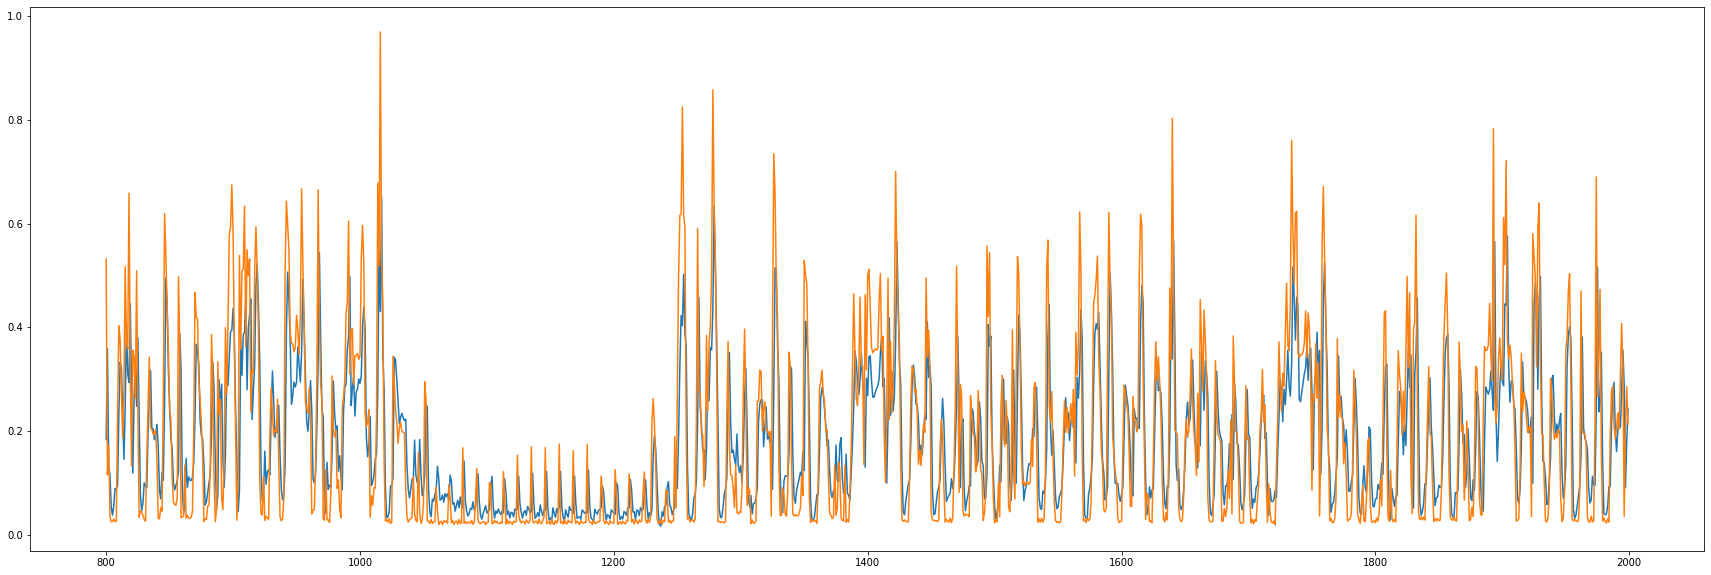

In [128]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(train_results['train_predicted'][800:2000])
plt.plot(train_results['train_target'][800:2000])

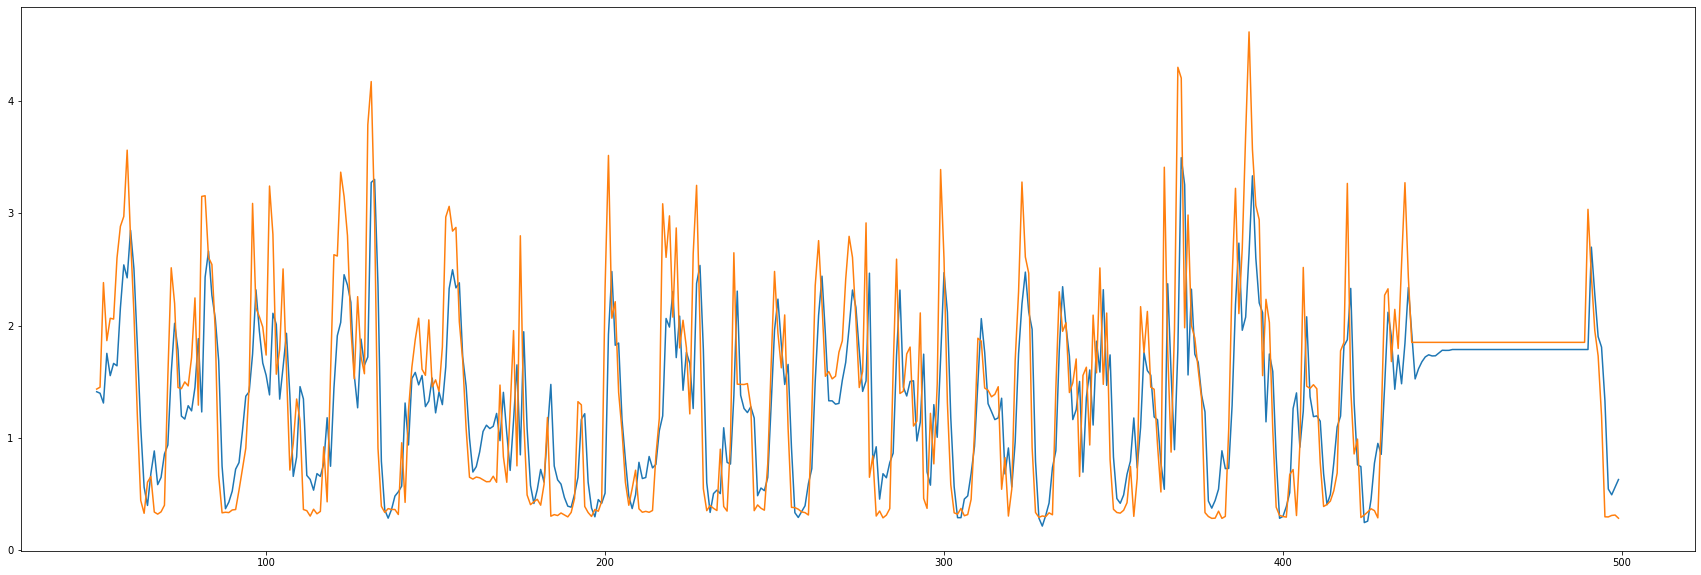

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(test_results['test_predicted'][50:500])
plt.plot(test_results['test_target'][50:500])

**MODEL2..Conv1D**

In [ ]:
model2 = Sequential()
model2.add(InputLayer((100, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp2])

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

In [ ]:
test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_absolute_percentage_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_absolute_percentage_error(train_results.train_predicted,train_results.train_target)

**Model3...GRU**

In [ ]:
model3 = Sequential()
model3.add(InputLayer((100, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(train_input, train_target, validation_data=(validation_input, validation_target), epochs=10, callbacks=[cp3])

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
train_predicted = model2.predict(train_input).flatten()
train_results = pd.DataFrame(data={'train_predicted':train_predicted, 'train_target':train_target.flatten()})

test_predictions = model2.predict(test_input).flatten()
test_results = pd.DataFrame(data={'test_predictions':test_predictions, 'test_target':test_target.flatten()})

In [ ]:
print(f"Test error...")
mean_squared_error(test_results.test_predictions,test_results.test_target)

In [ ]:
print(f"Training Error....")
mean_squared_error(train_results.train_predicted,train_results.train_target)